# Billboard Top 100

This dataset, available via Data.world, contains every weekly Hot 100 singles chart between 8/2/1958 and 12/28/2019 from Billboard.com. Each row of data represents a song and the corresponding position on that week's chart. Included in each row are the following elements:
1. Billboard Chart URL
2. WeekID
3. Song name
4. Performer name
5. SongID - Concatenation of song & performer
6. Current week on chart
7. Instance (this is used to separate breaks on the chart for a given song. Example, an instance of 6 tells you that this is the sixth time this song has appeared on the chart)
8. Previous week position
9. Peak Position (as of the corresponding week)
10. Weeks on Chart (as of the corresponding week)

Also available is a dataset containing each song's "audio features."

These include common attributes like genre as well as the following:
1. Danceability
2. Energy
3. Key
4. Loudness
5. Mode
6. Speechiness
7. Acousticness
8. Instrumentalness
9. Liveness
10. Valence
11. Tempo
12. Time Signature

Definitions of those terms are available at https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

Here's an example:

Liveliness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.



I'm excited about this data set. In addition to already numeric things like tempo, the ability to measure things like instrumentalness and speechiness give us some fun quantative measurements to play around with. I find change over time interesting, so I think I'm curious to see how things like average length of time on chart, average length of time on chart for #1 songs, and similar metrics change over time.

After exploring all that, I have a little bit of machine learning I'd like to do with this data set. First, I'd like to see what kind of clusters exist within some of the attributes available in the second data frame. Then I'm curious to see if I can use features from both dataframes to predict when a song originated.

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import datetime
register_matplotlib_converters()
import sklearn


# 1: Explore the data
Let's just explore the data sets, do some cleaning/preprocessing, and get a sense of what's in there.

In [3]:
df1= pd.read_csv("Hot Stuff.csv")
print(len(df1))
print(df1.dtypes)
df1.head()

320495
url                        object
WeekID                     object
Week Position               int64
Song                       object
Performer                  object
SongID                     object
Instance                    int64
Previous Week Position    float64
Peak Position               int64
Weeks on Chart              int64
dtype: object


,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
0,http://www.billboard.com/charts/hot-100/1958-0...,8/2/1958,1,Poor Little Fool,Ricky Nelson,Poor Little FoolRicky Nelson,1,NaN,1,1
1,http://www.billboard.com/charts/hot-100/1995-1...,12/2/1995,1,One Sweet Day,Mariah Carey & Boyz II Men,One Sweet DayMariah Carey & Boyz II Men,1,NaN,1,1
2,http://www.billboard.com/charts/hot-100/1997-1...,10/11/1997,1,Candle In The Wind 1997/Something About The Wa...,Elton John,Candle In The Wind 1997/Something About The Wa...,1,NaN,1,1
3,http://www.billboard.com/charts/hot-100/2006-0...,7/1/2006,1,Do I Make You Proud,Taylor Hicks,Do I Make You ProudTaylor Hicks,1,NaN,1,1
4,http://www.billboard.com/charts/hot-100/2009-1...,10/24/2009,1,3,Britney Spears,3Britney Spears,1,NaN,1,1


In [4]:
df1['WeekID']=pd.to_datetime(df1['WeekID'], infer_datetime_format=True) #Let's convert WeekID to a date, then we can use max functions to find the most recent WeekID

In [5]:
df1.isnull().sum()

url                           0
WeekID                        0
Week Position                 0
Song                          0
Performer                     0
SongID                        0
Instance                      0
Previous Week Position    30784
Peak Position                 0
Weeks on Chart                0
dtype: int64

This is actually a really clean set. Those missing Previous Week Position values are all from songs appearing on the chart for the first time and shouldn't have a value there. I'm going to tidy this data by defining an observation to be the number of weeks a song was on the chart, it's peak position, and it's final Week ID

In [6]:
df1['Song']

0                                          Poor Little Fool
1                                             One Sweet Day
2         Candle In The Wind 1997/Something About The Wa...
3                                       Do I Make You Proud
4                                                         3
                                ...                        
320490                                     Jingle Bell Rock
320491                                     Jingle Bell Rock
320492                                     Jingle Bell Rock
320493                                     Jingle Bell Rock
320494                                     Jingle Bell Rock
Name: Song, Length: 320495, dtype: object

In [7]:
df1[df1['Song'] == 'Jingle Bell Rock']

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
14317,http://www.billboard.com/charts/hot-100/1958-1...,1958-12-20,57,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,1,NaN,57,1
28510,http://www.billboard.com/charts/hot-100/1961-1...,1961-12-09,71,Jingle Bell Rock,Bobby Rydell/Chubby Checker,Jingle Bell RockBobby Rydell/Chubby Checker,1,NaN,71,1
85018,http://www.billboard.com/charts/hot-100/1958-1...,1958-12-27,35,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,1,57.0,35,2
85502,http://www.billboard.com/charts/hot-100/1961-1...,1961-12-16,45,Jingle Bell Rock,Bobby Rydell/Chubby Checker,Jingle Bell RockBobby Rydell/Chubby Checker,1,71.0,45,2
116000,http://www.billboard.com/charts/hot-100/1962-0...,1962-01-06,21,Jingle Bell Rock,Bobby Rydell/Chubby Checker,Jingle Bell RockBobby Rydell/Chubby Checker,1,27.0,21,5
126618,http://www.billboard.com/charts/hot-100/1961-1...,1961-12-23,27,Jingle Bell Rock,Bobby Rydell/Chubby Checker,Jingle Bell RockBobby Rydell/Chubby Checker,1,45.0,27,3
127909,http://www.billboard.com/charts/hot-100/1959-0...,1959-01-03,45,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,1,35.0,35,3
177460,http://www.billboard.com/charts/hot-100/1961-1...,1961-12-30,21,Jingle Bell Rock,Bobby Rydell/Chubby Checker,Jingle Bell RockBobby Rydell/Chubby Checker,1,27.0,21,4
183140,http://www.billboard.com/charts/hot-100/1959-0...,1959-01-10,70,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,1,45.0,35,4
217855,http://www.billboard.com/charts/hot-100/1962-0...,1962-01-13,23,Jingle Bell Rock,Bobby Rydell/Chubby Checker,Jingle Bell RockBobby Rydell/Chubby Checker,1,21.0,21,6


Hmm, a few occurences of Jingle Bell Rock. Let's see how many and when they appear.

In [8]:
df1[(df1['Song']=='Jingle Bell Rock')].sort_values(by='Weeks on Chart', ascending = False)

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
320494,https://www.billboard.com/charts/hot-100/2019-...,2019-12-28,9,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,15.0,9,29
320493,https://www.billboard.com/charts/hot-100/2019-...,2019-12-21,15,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,23.0,15,28
320492,https://www.billboard.com/charts/hot-100/2019-...,2019-12-14,23,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,47.0,23,27
320491,https://www.billboard.com/charts/hot-100/2019-...,2019-12-07,47,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,NaN,47,26
320490,https://www.billboard.com/charts/hot-100/2019-...,2019-01-05,8,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,13.0,8,25
320489,https://www.billboard.com/charts/hot-100/2018-...,2018-12-29,13,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,15.0,13,24
320488,https://www.billboard.com/charts/hot-100/2018-...,2018-12-22,15,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,26.0,15,23
320487,https://www.billboard.com/charts/hot-100/2018-...,2018-12-15,26,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,33.0,26,22
320486,https://www.billboard.com/charts/hot-100/2018-...,2018-12-08,33,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,NaN,33,21
320470,http://www.billboard.com/charts/hot-100/2017-0...,2017-01-07,29,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,6,46.0,29,20


So in addition to there being two different versions of Jingle Bell Rock, it looks like 'Weeks on Chart' allows for nonconsecutive weeks and 'Instance' tracks the nth time a song has entered the chart after having fallen off. Bobby Helms jumped from 1962 to 2016 and then showed up as recently as 2018. In a separate analysis, I might be interested in how Christmas music has changed over time. I could also use the point where Christmas music enters the chart to measure "Christmas Creep," the feeling that the Christmas season begins earlier each year.

In [9]:
df1[(df1['Song']=='Jingle Bell Rock') & (df1['Performer'] =='Bobby Helms')].sort_values(by='Weeks on Chart', ascending = False)

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
320494,https://www.billboard.com/charts/hot-100/2019-...,2019-12-28,9,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,15.0,9,29
320493,https://www.billboard.com/charts/hot-100/2019-...,2019-12-21,15,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,23.0,15,28
320492,https://www.billboard.com/charts/hot-100/2019-...,2019-12-14,23,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,47.0,23,27
320491,https://www.billboard.com/charts/hot-100/2019-...,2019-12-07,47,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,NaN,47,26
320490,https://www.billboard.com/charts/hot-100/2019-...,2019-01-05,8,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,13.0,8,25
320489,https://www.billboard.com/charts/hot-100/2018-...,2018-12-29,13,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,15.0,13,24
320488,https://www.billboard.com/charts/hot-100/2018-...,2018-12-22,15,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,26.0,15,23
320487,https://www.billboard.com/charts/hot-100/2018-...,2018-12-15,26,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,33.0,26,22
320486,https://www.billboard.com/charts/hot-100/2018-...,2018-12-08,33,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,NaN,33,21
320470,http://www.billboard.com/charts/hot-100/2017-0...,2017-01-07,29,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,6,46.0,29,20


I'm interested in seeing how the amount of time each song spends on the chart changes over time. So I'm going to make each chart it's own observation and then average the values in that chart. Now 'Weeks on Chart' will represent the average number of weeks each song on that chart has been on Billboard's top 100.

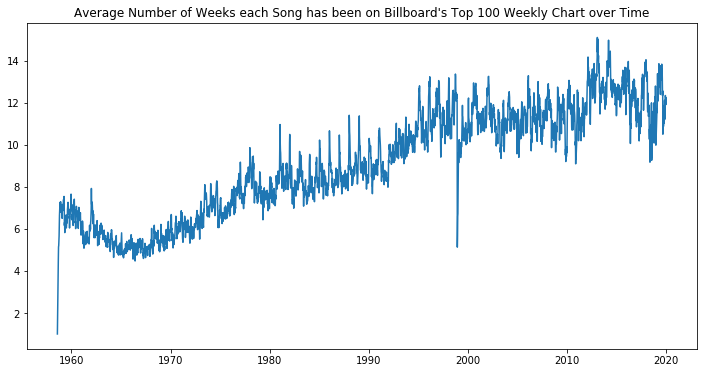

In [10]:
mean = df1.groupby('WeekID').mean().sort_values('WeekID', ascending=True)
#median = df1.groupby('WeekID').median().sort_values('WeekID', ascending=True)
#mean.head()
plt.figure(figsize=(12,6))
plt.title("Average Number of Weeks each Song has been on Billboard's Top 100 Weekly Chart over Time")
plt.plot(mean['Weeks on Chart']);

So there are a couple things we notice on this graph. First, there's that initial jump because the first few charts had no real values for "Weeks on Chart". 

Second, I'm quite surprised by the very clear upward trend!

Last, that dip just before 2000 is unusual. Let's figure out when it is.

In [45]:
mean[(mean['Weeks on Chart'] < 6) & (mean['WeekID'] > datetime.datetime(1988,1,1))]

,Week Position,Instance,Previous Week Position,Peak Position,Weeks on Chart,WeekID
WeekID,,,,,,
1998-12-05,50.5,1.01,28.820513,42.18,5.13,1998-12-05
1998-12-12,50.5,1.01,48.916667,41.95,5.69,1998-12-12


In [46]:
df1[(df1['WeekID']== datetime.datetime(1998,12,5)) & (df1['Weeks on Chart']== 1 )]

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
143,http://www.billboard.com/charts/hot-100/1998-1...,1998-12-05,14,Save Tonight,Eagle-Eye Cherry,Save TonightEagle-Eye Cherry,1,NaN,14,1
825,http://www.billboard.com/charts/hot-100/1998-1...,1998-12-05,17,Thank U,Alanis Morissette,Thank UAlanis Morissette,1,NaN,17,1
882,http://www.billboard.com/charts/hot-100/1998-1...,1998-12-05,21,Are You That Somebody?,Aaliyah,Are You That Somebody?Aaliyah,1,NaN,21,1
932,http://www.billboard.com/charts/hot-100/1998-1...,1998-12-05,25,Slide,Goo Goo Dolls,SlideGoo Goo Dolls,1,NaN,25,1
1154,http://www.billboard.com/charts/hot-100/1998-1...,1998-12-05,38,Real World,matchbox 20,Real Worldmatchbox 20,1,NaN,38,1
3350,http://www.billboard.com/charts/hot-100/1998-1...,1998-12-05,53,Right On The Money,Alan Jackson,Right On The MoneyAlan Jackson,1,NaN,53,1
4762,http://www.billboard.com/charts/hot-100/1998-1...,1998-12-05,1,I'm Your Angel,R. Kelly & Celine Dion,I'm Your AngelR. Kelly & Celine Dion,1,NaN,1,1
4802,http://www.billboard.com/charts/hot-100/1998-1...,1998-12-05,5,From This Moment On,Shania Twain,From This Moment OnShania Twain,1,NaN,5,1
4846,http://www.billboard.com/charts/hot-100/1998-1...,1998-12-05,9,Iris,Goo Goo Dolls,IrisGoo Goo Dolls,1,NaN,9,1
8146,http://www.billboard.com/charts/hot-100/1998-1...,1998-12-05,59,Tearin' Up My Heart,'N Sync,Tearin' Up My Heart'N Sync,1,NaN,59,1


Some other things I could pull from here that might be interesting include what are the greatest and worst charts of all time, be it by most weeks spent on the chart or by average peak position. I could look at smaller subsets of this dataThere's a lot of fun stuff here that I might look at in a future analysis.

I'd like to collapse the data so each song has a single entry on the chart including the last week it was on the chart, it's peak position, and the number of weeks spent on the chart.

In [97]:
new_df1 = df1.groupby('SongID').agg({'WeekID':'max', 'Peak Position':'min', 'Weeks on Chart':'max' })[['WeekID', 'Peak Position','Weeks on Chart']].reset_index()

In [98]:
print(new_df1.isnull().sum())
print(len(new_df1))
new_df1.head()

SongID            0
WeekID            0
Peak Position     0
Weeks on Chart    0
dtype: int64
28474


,SongID,WeekID,Peak Position,Weeks on Chart
0,"""B"" GirlsYoung And Restless",1990-08-11,54,15
1,"""Cherry Cherry"" from Hot August NightNeil Diamond",1973-05-19,31,10
2,"""Having A Party"" MedleyThe Ovations (Featuring...",1973-12-08,56,9
3,"""Joy"" Pt. IIsaac Hayes",1974-02-16,30,9
4,"""Roots"" MedleyQuincy Jones",1977-04-16,57,7


 # Here Here Here Here Here Here

In [145]:
df2 = pd.read_excel("Song_data.xlsx")
df2.head()

,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_album,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],3jbT1Y5MoPwEIpZndDDwVq,NaN,Adicto (with Anuel AA & Ozuna),0.0,270740.0,91.0,...,10.0,-4.803,0.0,0.0735,0.01700,0.000016,0.1790,0.623,80.002,4.0
1,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",2VxeLyX666F8uXCJ0dZF8B,NaN,A Star Is Born Soundtrack,0.0,215733.0,88.0,...,7.0,-6.362,1.0,0.0308,0.37100,0.000000,0.2310,0.323,95.799,4.0
3,EnemiesPost Malone Featuring DaBaby,Post Malone Featuring DaBaby,Enemies,"['dfw rap', 'melodic rap', 'rap']",0Xek5rqai2jcOWCYWJfVCF,NaN,Hollywood's Bleeding,1.0,196760.0,86.0,...,6.0,-4.169,1.0,0.2100,0.05880,0.000000,0.0955,0.667,76.388,4.0
4,"Bacc At It AgainYella Beezy, Gucci Mane & Quavo","Yella Beezy, Gucci Mane & Quavo",Bacc At It Again,"['dfw rap', 'rap', 'southern hip hop', 'trap']",2biNa12dMbHJrHVFRt8JyO,https://p.scdn.co/mp3-preview/fa6fa6f6f363be29...,Bacc At It Again,1.0,228185.0,61.0,...,8.0,-5.725,0.0,0.1680,0.00124,0.000001,0.0716,0.856,135.979,4.0


In [146]:
df2 = df2.drop(columns= ['Performer', 'Song', 'spotify_genre', 'spotify_track_preview_url','spotify_track_id', 'spotify_track_album'])

In [148]:
df2.head()

,SongID,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"AdictoTainy, Anuel AA & Ozuna",0.0,270740.0,91.0,0.734,0.836,10.0,-4.803,0.0,0.0735,0.01700,0.000016,0.1790,0.623,80.002,4.0
1,The Ones That Didn't Make It Back HomeJustin M...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,0.0,215733.0,88.0,0.572,0.385,7.0,-6.362,1.0,0.0308,0.37100,0.000000,0.2310,0.323,95.799,4.0
3,EnemiesPost Malone Featuring DaBaby,1.0,196760.0,86.0,0.542,0.674,6.0,-4.169,1.0,0.2100,0.05880,0.000000,0.0955,0.667,76.388,4.0
4,"Bacc At It AgainYella Beezy, Gucci Mane & Quavo",1.0,228185.0,61.0,0.948,0.623,8.0,-5.725,0.0,0.1680,0.00124,0.000001,0.0716,0.856,135.979,4.0


In [149]:
df2.isnull().sum()

SongID                          0
spotify_track_explicit       4749
spotify_track_duration_ms    4749
spotify_track_popularity     4749
danceability                 4812
energy                       4812
key                          4812
loudness                     4812
mode                         4812
speechiness                  4812
acousticness                 4812
instrumentalness             4812
liveness                     4812
valence                      4812
tempo                        4812
time_signature               4812
dtype: int64

It seems really likely that those 4812 entries in each of danceability thru time_signature are files that just didn't get analyzed by the audio feature extractor and that by dropping all of them, I'm only losing 4812 entries.

In [150]:
df2 = df2.dropna()
print(len(df2))
df2.isnull().sum()

23676


SongID                       0
spotify_track_explicit       0
spotify_track_duration_ms    0
spotify_track_popularity     0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                         0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
time_signature               0
dtype: int64

Sweet, we had 28492 entries and after dropping we have 23676. So we lost 4816 entries, 4 more songs than hoped for. I'll take that.

Now I'm going to push SongID into the index so the rest of the dataframe is numeric and I can scale the data.

In [152]:
save_index = df2['SongID']
df2 = df2.set_index('SongID')
df2

,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
SongID,,,,,,,,,,,,,,,
"AdictoTainy, Anuel AA & Ozuna",0.0,270740.0,91.0,0.734,0.836,10.0,-4.803,0.0,0.0735,0.017000,0.000016,0.1790,0.623,80.002,4.0
ShallowLady Gaga & Bradley Cooper,0.0,215733.0,88.0,0.572,0.385,7.0,-6.362,1.0,0.0308,0.371000,0.000000,0.2310,0.323,95.799,4.0
EnemiesPost Malone Featuring DaBaby,1.0,196760.0,86.0,0.542,0.674,6.0,-4.169,1.0,0.2100,0.058800,0.000000,0.0955,0.667,76.388,4.0
"Bacc At It AgainYella Beezy, Gucci Mane & Quavo",1.0,228185.0,61.0,0.948,0.623,8.0,-5.725,0.0,0.1680,0.001240,0.000001,0.0716,0.856,135.979,4.0
The ArcherTaylor Swift,0.0,211240.0,76.0,0.292,0.574,0.0,-9.375,1.0,0.0401,0.120000,0.005690,0.0663,0.166,124.344,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Tonight, Tonight, TonightGenesis",0.0,530560.0,42.0,0.571,0.502,7.0,-14.405,1.0,0.0303,0.015800,0.014000,0.0849,0.316,98.058,4.0
"Tonight, TonightThe Smashing Pumpkins",0.0,254626.0,69.0,0.287,0.670,6.0,-9.381,1.0,0.0368,0.000063,0.748000,0.2370,0.222,148.928,4.0
Tonight's The Night (Gonna Be Alright)Rod Stewart,0.0,237120.0,55.0,0.550,0.514,11.0,-12.617,1.0,0.0523,0.336000,0.125000,0.3820,0.724,136.542,3.0


In [153]:
from sklearn import preprocessing

In [154]:
min_max_scaler = preprocessing.MinMaxScaler()
df2_scaled = min_max_scaler.fit_transform(df2)
df2_scaled = pd.DataFrame(df2_scaled)

In [156]:
df2 = df2_scaled.set_index(save_index)

In [157]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
SongID,,,,,,,,,,,,,,,
"AdictoTainy, Anuel AA & Ozuna",0.0,0.079047,0.91,0.742915,0.838421,0.909091,0.766037,0.0,0.077287,0.017152,0.000017,0.171156,0.628658,0.331946,0.8
ShallowLady Gaga & Bradley Cooper,0.0,0.061009,0.88,0.578947,0.385801,0.636364,0.714620,1.0,0.032387,0.374368,0.000000,0.223717,0.325933,0.397491,0.8
EnemiesPost Malone Featuring DaBaby,1.0,0.054787,0.86,0.548583,0.675839,0.545455,0.786946,1.0,0.220820,0.059332,0.000000,0.086756,0.673058,0.316951,0.8
"Bacc At It AgainYella Beezy, Gucci Mane & Quavo",1.0,0.065092,0.61,0.959514,0.624656,0.727273,0.735629,0.0,0.176656,0.001249,0.000001,0.062598,0.863774,0.564207,0.8
The ArcherTaylor Swift,0.0,0.059536,0.76,0.295547,0.575480,0.000000,0.615250,1.0,0.042166,0.121088,0.005794,0.057241,0.167508,0.515931,0.8


In [160]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(df2)



In [161]:
kmeans.labels_


array([3, 0, 2, ..., 0, 3, 1])

In [180]:
Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df2)
    Sum_of_squared_distances.append(km.inertia_)


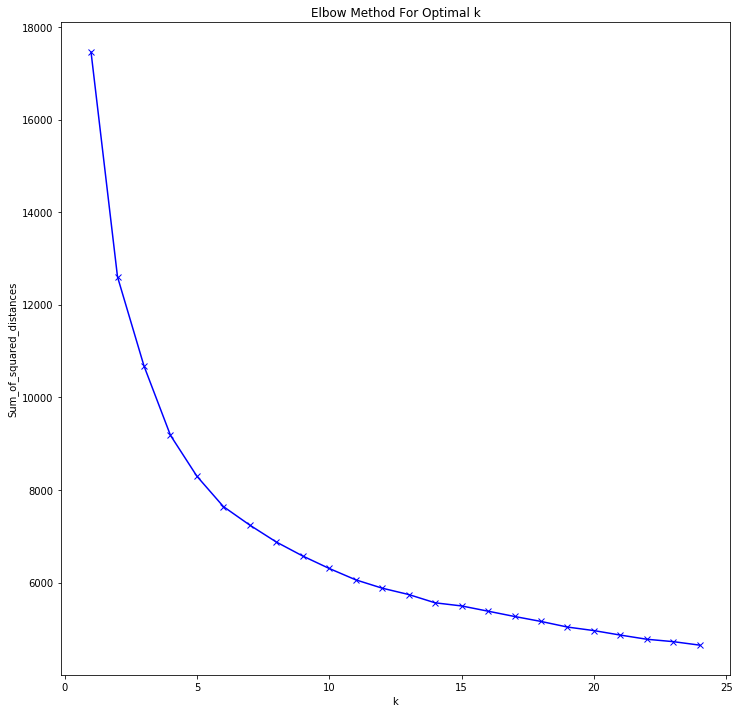

In [177]:
plt.figure(figsize=(12,12))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show();

# Things to do next time:
1. Get silhouette shading to work
2. compare "central" songs. See what songs are the center of each cluster, how different those centers are.
3. Attach this to the original DF. Songs that 

Para n_clusters = 2 O score_silhouette médio é : 0.3197415683142129


TypeError: '(slice(None, None, None), 0)' is an invalid key

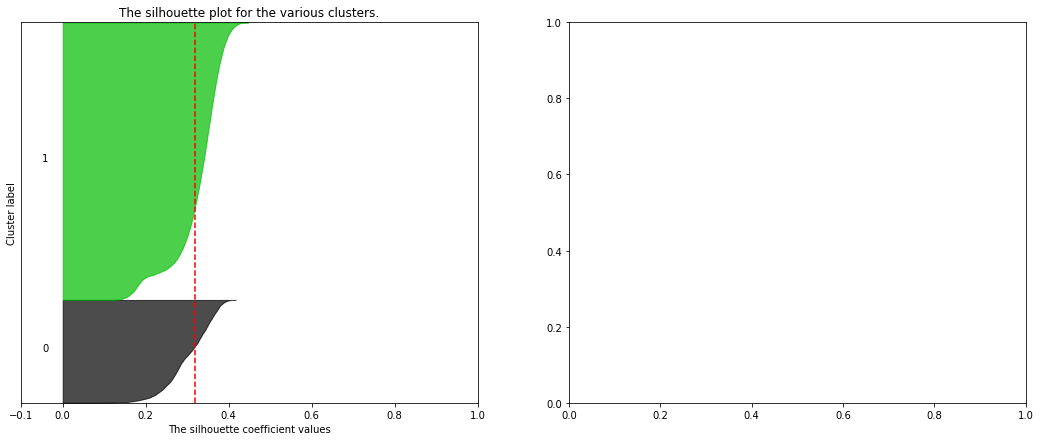

In [186]:
range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df2) + (n_clusters + 1) * 10])
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df2)
# The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = sklearn.metrics.silhouette_score(df2, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette médio é :", silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(df2, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df2[:, 0], df2[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

So, while we have quite a bit less of the dataframe, 28474 of the original 320k rows, we can start to look at some of the relationships between Peak Position and Weeks on Chart. I'd like to look at the mean and median time spent on the chart of a top 100 song and I'd also like to explore differences in those averages over time.

In [49]:
new_df1.sort_values('Weeks on Chart', ascending= False)

,SongID,WeekID,Peak Position,Weeks on Chart
18864,RadioactiveImagine Dragons,2014-05-10,3,87
19821,SailAWOLNATION,2014-03-22,17,79
11718,I'm YoursJason Mraz,2009-10-10,6,76
9827,How Do I LiveLeAnn Rimes,1998-10-10,2,69
18096,Party Rock AnthemLMFAO Featuring Lauren Bennet...,2012-07-21,1,68
...,...,...,...,...
6724,FallingHarry Styles,2019-12-28,62,1
23298,The Blacker The BerryKendrick Lamar,2015-04-04,66,1
11588,I'm MeLil Wayne,2008-02-16,97,1
26800,When You Dance I Can Really LoveNeil Young,1971-04-10,93,1


At first I was a little suspicious that a song spending 87 weeks on the chart wouldn't have made it all the way to # 1, but from Wikipedia's article on Radioactive by Imagine Dragons:

"...the song became a sleeper hit, peaking at number three on the US Billboard Hot 100 chart and becoming the band's first top 10 single as well as being the third best selling song in that country in 2013.[2] It also broke the record for slowest ascension to the top 5 in chart history[3] and currently holds the record for most weeks spent on the Billboard Hot 100 at 87 weeks."

count    2105.000000
mean       82.507838
std        17.880732
min         5.000000
25%        73.000000
50%        89.000000
75%        96.000000
max       100.000000
Name: Peak Position, dtype: float64


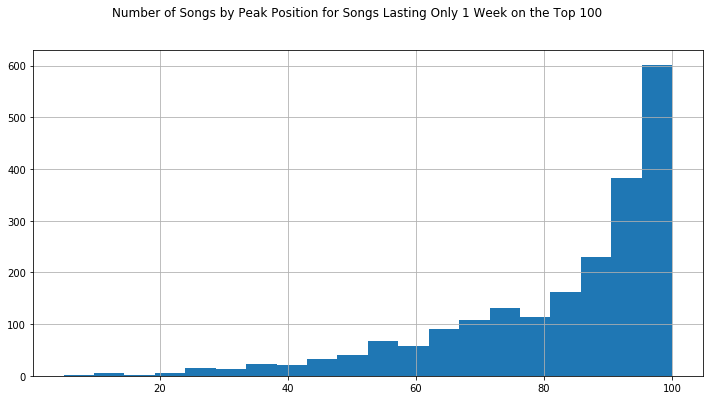

In [50]:
print(new_df1[new_df1['Weeks on Chart'] == 1]['Peak Position'].describe())
new_df1[new_df1['Weeks on Chart'] == 1]['Peak Position'].hist(bins=20, figsize=(12,6))
plt.suptitle( 'Number of Songs by Peak Position for Songs Lasting Only 1 Week on the Top 100');

count    28474.000000
mean        46.521283
std         30.589048
min          1.000000
25%         18.000000
50%         46.000000
75%         73.000000
max        100.000000
Name: Peak Position, dtype: float64


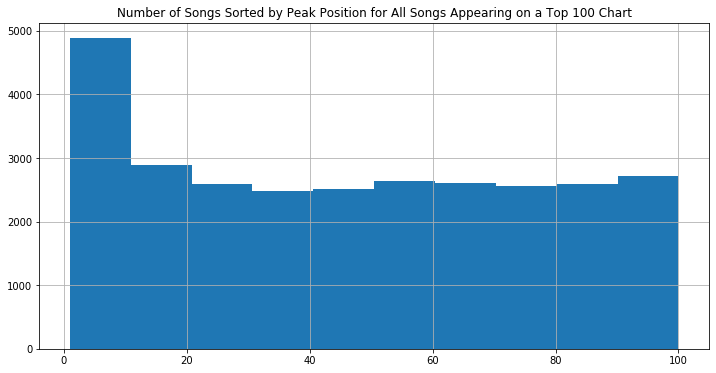

In [14]:
print(new_df1['Peak Position'].describe())
new_df1['Peak Position'].hist(bins=10, figsize=(12,6))
plt.title( 'Number of Songs Sorted by Peak Position for All Songs Appearing on a Top 100 Chart');

This is somewhat tricky to read. It seems counterintuitive that a Peak Position of 1-10 would account for so many more songs than any other bin, but those songs take up a ton of space throughout the chart both on their way up and down. Let's look at one of them.

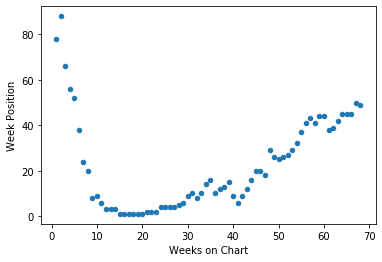

In [15]:
df1[df1['SongID']=='Party Rock AnthemLMFAO Featuring Lauren Bennett & GoonRock'].plot(kind='scatter', x='Weeks on Chart', y='Week Position');

We see that song is very high after about 15 weeks, stays there for 10 weeks or so, then spends weeks 25 to 70 working it's way off the chart.

Moving on, let's start to look at some of these things over time.

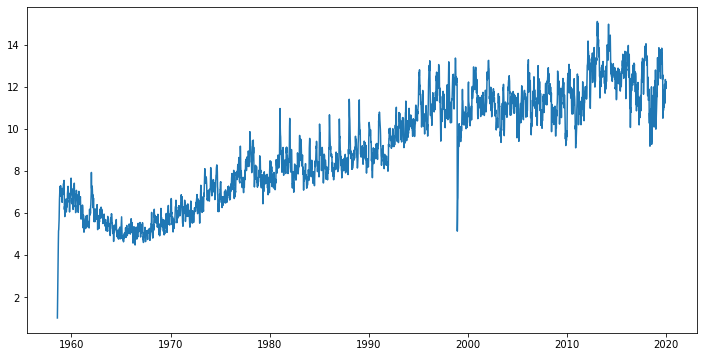

In [10]:
tryd = df1.groupby('WeekID').mean().sort_values('WeekID', ascending=True)
tryd.head()
plt.figure(figsize=(12,6))
plt.plot(tryd['Weeks on Chart']);

In [56]:
new_df1[new_df1['Peak Position'] == 1].sort_values('Weeks on Chart')

,SongID,WeekID,Peak Position,Weeks on Chart
9009,HeartlessThe Weeknd,2019-12-28,1,4
5288,Do I Make You ProudTaylor Hicks,2006-08-19,1,8
14633,Lose You To Love MeSelena Gomez,2019-12-28,1,9
3527,Can't Buy Me LoveThe Beatles,1964-05-30,1,10
6224,Eight Days A WeekThe Beatles,1965-04-24,1,10
...,...,...,...,...
1121,All Of MeJohn Legend,2014-12-06,1,59
21281,Somebody That I Used To KnowGotye Featuring Ki...,2013-03-02,1,59
15251,Macarena (Bayside Boys Mix)Los Del Rio,1997-02-08,1,60
19544,Rolling In The DeepAdele,2012-04-14,1,65


9.330364820046677

13.835219816272966

,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_album,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],3jbT1Y5MoPwEIpZndDDwVq,NaN,Adicto (with Anuel AA & Ozuna),0.0,270740.0,91.0,...,10.0,-4.803,0.0,0.0735,0.01700,0.000016,0.1790,0.623,80.002,4.0
1,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",2VxeLyX666F8uXCJ0dZF8B,NaN,A Star Is Born Soundtrack,0.0,215733.0,88.0,...,7.0,-6.362,1.0,0.0308,0.37100,0.000000,0.2310,0.323,95.799,4.0
3,EnemiesPost Malone Featuring DaBaby,Post Malone Featuring DaBaby,Enemies,"['dfw rap', 'melodic rap', 'rap']",0Xek5rqai2jcOWCYWJfVCF,NaN,Hollywood's Bleeding,1.0,196760.0,86.0,...,6.0,-4.169,1.0,0.2100,0.05880,0.000000,0.0955,0.667,76.388,4.0
4,"Bacc At It AgainYella Beezy, Gucci Mane & Quavo","Yella Beezy, Gucci Mane & Quavo",Bacc At It Again,"['dfw rap', 'rap', 'southern hip hop', 'trap']",2biNa12dMbHJrHVFRt8JyO,https://p.scdn.co/mp3-preview/fa6fa6f6f363be29...,Bacc At It Again,1.0,228185.0,61.0,...,8.0,-5.725,0.0,0.1680,0.00124,0.000001,0.0716,0.856,135.979,4.0


In [36]:
df2.sort_values('SongID')

,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_album,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
10308,"""B"" GirlsYoung And Restless",Young And Restless,"""B"" Girls",[],0rWUHulFlScxQsCq7kWKde,https://p.scdn.co/mp3-preview/c551cbcaadd17bf4...,Something To Get You Hyped,0.0,242106.0,20.0,...,7.0,-11.913,1.0,0.4390,0.0160,0.000000,0.3120,0.769,193.762,3.0
12928,"""Cherry Cherry"" from Hot August NightNeil Diamond",Neil Diamond,"""Cherry Cherry"" from Hot August Night","['adult standards', 'brill building pop', 'fol...",18ocy9Be9SxWEEnOLGDfkS,NaN,Hot August Night / NYC (Live From Madison Squa...,0.0,443320.0,16.0,...,9.0,-5.061,1.0,0.1370,0.0941,0.000907,0.8670,0.604,172.349,4.0
19355,"""Having A Party"" MedleyThe Ovations (Featuring...",The Ovations (Featuring Louis Williams),"""Having A Party"" Medley","['memphis soul', 'southern soul']",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11563,"""Joy"" Pt. IIsaac Hayes",Isaac Hayes,"""Joy"" Pt. I","['classic soul', 'disco', 'funk', 'jazz funk',...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19935,"""Roots"" MedleyQuincy Jones",Quincy Jones,"""Roots"" Medley","['adult standards', 'disco', 'funk', 'jazz fun...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6128,teachmeMusiq Soulchild,Musiq Soulchild,teachme,"['alternative r&b', 'dance pop', 'neo soul', '...",0ODFPypnJLE6hKgahiuSzn,https://p.scdn.co/mp3-preview/0a49d387a7ecc54d...,Luvanmusiq,0.0,260017.0,57.0,...,8.0,-5.110,0.0,0.1350,0.4730,0.000000,0.0722,0.436,172.969,3.0
25353,whoa (mind in awe)XXXTENTACION,XXXTENTACION,whoa (mind in awe),"['emo rap', 'miami hip hop']",7pdF27mSDuPWhppnHAmWHa,https://p.scdn.co/mp3-preview/f69b47e8941ef8f4...,SKINS,0.0,157776.0,77.0,...,6.0,-2.939,0.0,0.0441,0.6530,0.918000,0.1010,0.369,160.147,4.0
25358,whoknowsMusiq,Musiq,whoknows,"['alternative r&b', 'dance pop', 'neo soul', '...",69rOfKSz0ys8UdgTkGd6qV,NaN,soulstar,0.0,295320.0,39.0,...,2.0,-6.144,1.0,0.1220,0.2300,0.000000,0.3390,0.316,118.862,4.0
25845,www.memoryAlan Jackson,Alan Jackson,www.memory,"['contemporary country', 'country', 'country r...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df2.columns

Index(['SongID', 'Performer', 'Song', 'spotify_genre', 'spotify_track_id',
       'spotify_track_preview_url', 'spotify_track_album',
       'spotify_track_explicit', 'spotify_track_duration_ms',
       'spotify_track_popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')

I can use 'SongID' to join the dataframes. I'd like to clean the genre information up a bit. I don't need to keep the spotify information, but I want everything from danceability to time_signature.

### Work on next time:

df1: construct df and plot averages over time
     test for significance

df2:
    expand genre column
    remove columns
    join data
    deal with missing information
    look for trends in numeric values
    